In [ ]:
!pip install numpy matplotlib progressbar2 torch torchvision


In [1]:
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import progressbar
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
from torchvision.utils import make_grid  

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.utils as vutils  # Import make_grid from torchvision

##### OUTPUT_DIR = './data/CIFAR-10'

BATCH_SIZE = 500

LR = 0.0002

NUM_EPOCHS = 250

NUM_TEST_SAMPLES = 32

In [2]:
OUTPUT_DIR = './data/CIFAR-10'

BATCH_SIZE = 200

LR = 0.0004

NUM_EPOCHS = 150

NUM_TEST_SAMPLES = 32

The load_cats_dogs_data function loads the CIFAR-10 dataset, applies transformations like resizing, tensor conversion, and normalization, and filters the dataset to retain only the images labeled as cats (label 3) and dogs (label 5). It returns this subset of cat and dog images for further processing.

In [3]:
def load_cats_dogs_data():
    compose = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])
    
    full_data = datasets.CIFAR10(root=OUTPUT_DIR, train=True, transform=compose, download=True)
    
    cat_dog_indices = [i for i, (_, label) in enumerate(full_data) if label in [3, 5]]
    
    cat_dog_data = torch.utils.data.Subset(full_data, cat_dog_indices)
    
    return cat_dog_data


In [4]:

data = load_cats_dogs_data()

data_loader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)
NUM_BATCHES = len(data_loader)

print("No. of Batches = ", NUM_BATCHES)



Files already downloaded and verified
No. of Batches =  50



The show_images function reverses normalization, converts it to a NumPy array, and displays the image using Matplotlib without axes. The show_sample_images function retrieves a batch of images from the data_loader, selects a specified number of images, and uses show_images to display them in a grid format.

In [5]:

def show_images(images):
    images = images / 2 + 0.5  
    np_images = images.numpy()
    plt.imshow(np.transpose(np_images, (1, 2, 0)))
    plt.axis('off')  
    plt.show()


def show_sample_images(data_loader, num_images=5):
    data_iter = iter(data_loader)  
    images, _ = next(data_iter) 
    sample_images = images[:num_images]  
    show_images(torchvision.utils.make_grid(sample_images))  



In [ ]:

show_sample_images(data_loader, num_images=7)

The Discriminator class defines a convolutional neural network that processes input images to determine if they are real or fake. It consists of four convolutional layers with increasing depth, using LeakyReLU activations and batch normalization to stabilize training. The final layer flattens the output and applies a sigmoid function, producing a single value that represents the likelihood of the input image being real.








In [7]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False), nn.LeakyReLU(0.2, inplace=True))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True))
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(1024), nn.LeakyReLU(0.2, inplace=True))
        self.output = nn.Sequential(nn.Linear(1024*4*4, 1), nn.Sigmoid())

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.output(x)
        return x


The Generator class defines a neural network that generates images from random noise. It starts with a fully connected layer to transform the input noise into a feature map, then applies a series of transposed convolutional layers to upsample the data. Each deconvolution layer uses batch normalization and ReLU activation, except the final layer, which applies a Tanh activation to scale the output to the range of image pixel values. This process generates a realistic image from the input noise.

In [8]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True))
        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.deconv4 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False))
        self.output = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        
        # Convolutional layers
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        
        # Apply Tanh
        return self.output(x)

In [9]:
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): 
      return n.cuda()
    return n

In [10]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [11]:
generator = Generator()
discriminator = Discriminator()
generator.apply(init_weights)
discriminator.apply(init_weights)

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

In [12]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))


criterion = nn.BCELoss()


In [13]:
def real_data_target(size):
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): 
        return data.cuda()
    return data

def fake_data_target(size):
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): 
        return data.cuda()
    return data

In [14]:
def train_discriminator(optimizer, real_data, fake_data):

    optimizer.zero_grad()
    

    prediction_real = discriminator(real_data)
    
    error_real = criterion(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    prediction_fake = discriminator(fake_data)

    error_fake = criterion(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    

    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):

    optimizer.zero_grad()

    prediction = discriminator(fake_data)

    error = criterion(prediction, real_data_target(prediction.size(0)))
    error.backward()
    optimizer.step()
    return error

In [15]:
test_noise = noise(NUM_TEST_SAMPLES)

In [16]:
def generate_images(test_images, num_images, normalize=True):
  images = test_images
  
  horizontal_grid = vutils.make_grid(images, normalize=normalize, scale_each=True)
  nrows = int(np.sqrt(num_images))
  grid = vutils.make_grid(images, nrow=nrows, normalize=True, scale_each=True)

  fig = plt.figure(figsize=(16, 16))
  plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
  plt.axis('off')
  if True:
    display.display(plt.gcf())
  plt.close()

  fig = plt.figure()
  plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
  plt.axis('off')
  plt.close()

In [ ]:
for epoch in range(NUM_EPOCHS):
  print("\nEpoch #", epoch, "in progress...")
  progress_bar = progressbar.ProgressBar()
  d_running_loss = 0
  g_running_loss = 0
    
  for n_batch, (real_batch, _) in enumerate(progress_bar(data_loader)):    
    # 1. Train Discriminator
#     inputs, _ = real_batch
    real_data = Variable(real_batch)
    if torch.cuda.is_available(): 
      real_data = real_data.cuda()
    # Generate fake data
    fake_data = generator(noise(real_data.size(0))).detach()
    # Train D
    d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

    # 2. Train Generator
    # Generate fake data
    fake_data = generator(noise(real_batch.size(0)))
    # Train G
    g_error = train_generator(g_optimizer, fake_data)
    
    d_running_loss += d_error.item()
    g_running_loss += g_error.item()
  
    
#     loss = criterion(outputs, inputs)
  print("Loss (Discriminator):", d_running_loss)
  print("Loss (Generator):", g_running_loss)
    
  test_images = generator(test_noise).data.cpu()
  generate_images(test_images, NUM_TEST_SAMPLES)


In [18]:
torch.save(discriminator.state_dict(), 'Q2_discriminator.pth')

torch.save(generator.state_dict(), 'Q2_generator.pth')



print("Models saved successfully!")


Models saved successfully!


In [ ]:
discriminator = Discriminator()

generator = Generator()

In [ ]:
discriminator.load_state_dict(torch.load('Q2_discriminator.pth'))

generator.load_state_dict(torch.load('Q2_generator.pth'))

if torch.cuda.is_available():

    discriminator.cuda()

    generator.cuda()



print("Models loaded successfully!")


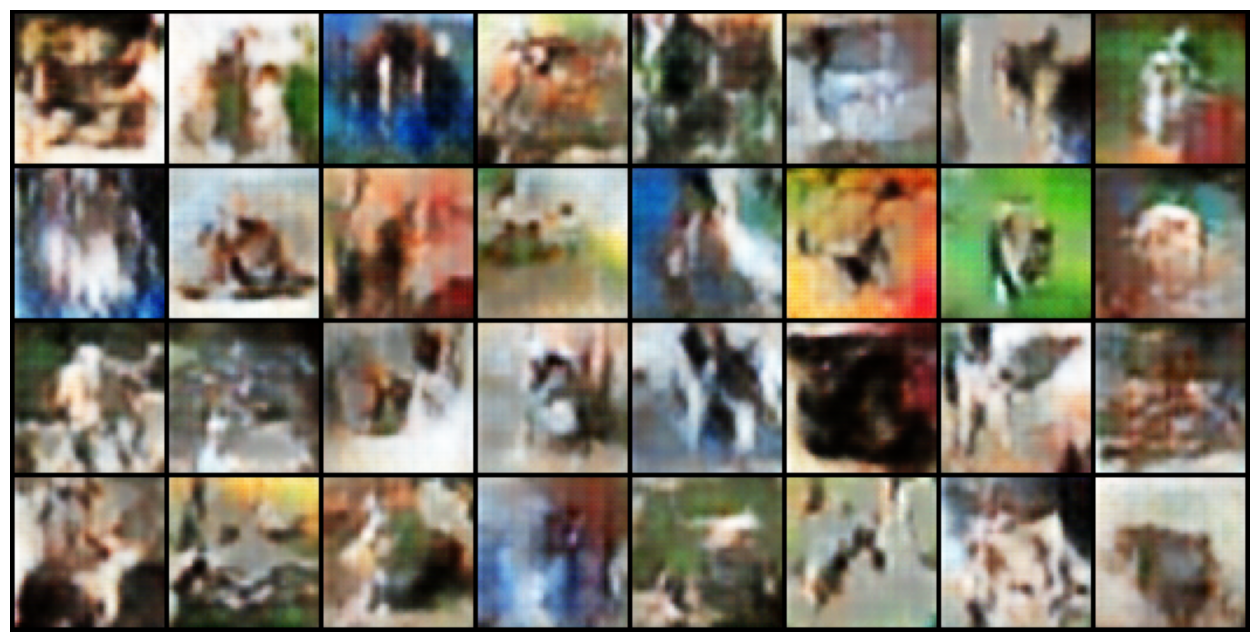

In [21]:
num_samples = NUM_TEST_SAMPLES
test_noise = noise(num_samples)
test_images = generator(test_noise).data.cpu()
generate_images(test_images, NUM_TEST_SAMPLES)